<div style="background-image:url(images/bertinoro.jpg); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 20px 0px 20px; background:rgba(255,255,255,0.6); border-radius:10px;">
<img width="400px" src=images/obspy_logo_full_524x179px.png?raw=true>
</p>

<h1 style="color:#333">First TIDES Training School</h1>
<h5 style="color:#FFF">Bertinoro (FC), Italy, June 1-5 2015</h5>

<h3 style="color:#EEE">Day 1: Data Acquisition and Processing with ObsPy</h3>

<h2 style="color:#FFF">Preparing data for Noise Spectra and Polarization Practical</h2>
</div>

##Prepare data for practical "Noise spectra and polarization"
In the practical on Tuesday we will find the direction of dominant oceanic noise sources, and see how they evolve along the year. For this, we will use continuous 3-component records from one of the stations in the Northern Italian network.  
We will download the data, remove the instrument response and cut them into equal length pieces. 

In [25]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [26]:
import numpy as np
import obspy
from obspy.fdsn import Client
from obspy import UTCDateTime
import os
import glob

noise_folder = "/home/tides/Desktop/data/noise_data"

##Step 1: get the data
- We can download the data from the INGV web service.  
- We will use station "TEOL" in Northern Italy. First, let's have a look at this station's response:

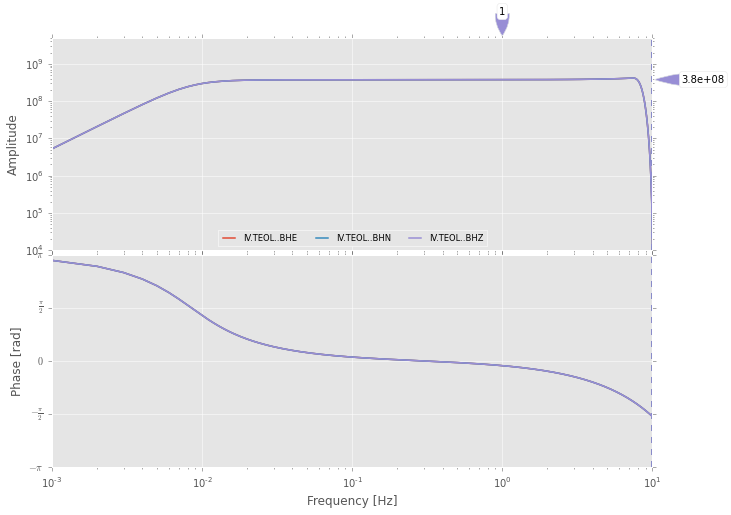

In [27]:
client = Client("INGV")
station = 'TEOL'
network = 'IV'

# get the instrument response
inv = client.get_stations(network=network, station=station, channel="BH?", level="response")
inv.plot_response(0.001);

- Since we want to see how the noise sources evolve along the year, we will use several days of continuous data per season. The start dates of each **'season'** are set here:

In [28]:
t = UTCDateTime(year=2014, julday=30)  #winter
season = "winter"

#t = UTCDateTime(year=2014, julday=70)  # spring
#season = "spring"

#t = UTCDateTime(year=2013, julday=180)   # summer
#season = "summer"

#t = UTCDateTime(year=2013, julday=280) # fall
#season = "fall"

###Option 1: Download the data from the INGV webservice:
You can uncomment the following block of code to download the data. However, if everyone tries to do this at the same time, we might run in to problems. The raw data for 10 days per season is therefore also provided on the virtual box. A bit further down in this notebook, you can also choose to read the provided data from disk (see option 2). 

- We will download 10 days of data per season:

In [29]:
#ndays = 10
#
#print("Downloading data....")
#
#st = obspy.Stream()
#for day in range(ndays):
#    try:
#        st += client.get_waveforms(network=network, station=station, location="", channel="BH?",
#                                   starttime=t + day * 86400, endtime=t + (day + 1) * 86400)
#    except:
#        print("No data for %s" % (t + day * 86400).strftime("%Y-%m-%d"))
#        pass
#
#st.attach_response(inv)
#print(st)
#st.plot()

- Uncomment the folowing to save the raw data you just downloaded:

In [30]:
#raw_folder = os.path.join(noise_folder, 'raw', "%s-%s-%s" % (t.year, station, season))
#if not os.path.exists(raw_folder):
#        os.makedirs(raw_folder)
#
#for tr in st: 
#    filename = tr.id + tr.stats.starttime.strftime("_%Y.%m.%d-%H.%M") + ".SAC"
#    tr.write(os.path.join(raw_folder, filename), format="SAC") 
#    
#print("Done. Raw data written to: %s", raw_folder)

### Option 2: read the data from disk:

- This will read the data which is already stored on the virtual box, instead of downloading.   
If you are using **option 1** above, comment out this block!

Finished reading. Available waveforms: 
 62 Trace(s) in Stream:

IV.TEOL..BHZ | 2014-02-04T20:57:31.845200Z - 2014-02-05T00:00:08.695200Z | 20.0 Hz, 219138 samples
...
(60 other traces)
...
IV.TEOL..BHZ | 2014-02-07T23:59:49.145300Z - 2014-02-09T00:00:19.495300Z | 20.0 Hz, 1728608 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


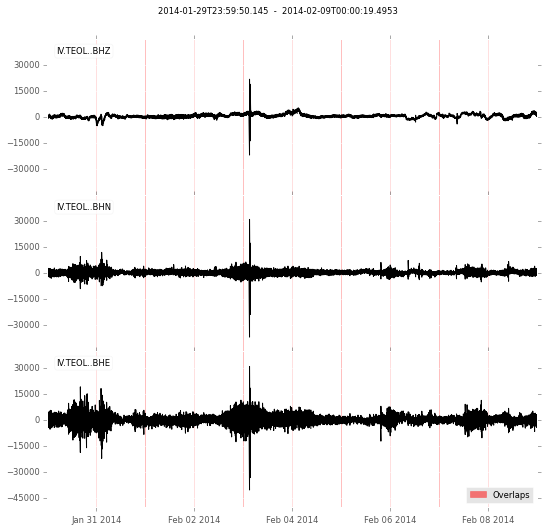

In [31]:
st = obspy.Stream()

raw_folder = os.path.join(noise_folder, 'raw', "%s-%s-%s" % (t.year, station, season))
list = glob.glob(os.path.join(raw_folder, "*%s*.SAC" % station))

for filename in list:
    st += obspy.read(filename)
    
print("Finished reading. Available waveforms: \n", st)
st.plot()

##Step 2: Clean the data
- Now prepare to remove the instrument response.  
We will downsample the data to 1Hz sampling rate afterwards, so make sure the pre-filtering you apply **eliminates frequencies below 0.5Hz!**  
**Note**: the actual response correction will take place later, on shorter timewindows, in order to speed up the process.

In [ ]:
# set the frequency ranges for the pre-filter:
f2 = 1.0 / 300.0 #max period
f3 = 1.0 / 3.0 #min period
f1 = 0.8 * f2
f4 = 1.3 * f3
pre_filt = (f1, f2, f3, f4)

# Removing the response for the whole 10 day stream is very slow. 
# If you really want to try, you can uncomment the following:
#for tr in st:
#    tr.remove_response(pre_filt=pre_filt, output="VEL")
#st.plot()

##Step 3: cut down seismograms into smaller pieces and save

- The polarization scripts we will use on Tuesday only accept signals with less than **8192 samples**. We will cut down our signals to 2-hour chunks.  
- After cutting out the chunks, we downsample the data from 20Hz to 1Hz. This will speed up subsequent processing.  
- We also make sure that the signals from all 3 components start and end at the same time (within the diff_threshold of 0.05 seconds)
- To save the data, first we have to create a directory structure with daily directories per station. The directory structure will also be built in this loop.  
**Example: Directory structure & filename**    
data/noise/2014-TEOL-winter/SAC_TRACES/2014.001/2014.001.00.00.TEOL.LHZ.sac   
data/noise/2014-TEOL-winter/SAC_TRACES/2014.002/2014.002.00.00.TEOL.LHZ.sac  



In [ ]:
# length of chunks in seconds:
length = 7200
# difference between start and endtime allowed, in seconds:
diff_threshold = 0.05

stf = st.copy()
stf.merge(fill_value="interpolate")

# find the earliest and latest times included in our complete signal
starttime = max([tr.stats.starttime for tr in stf])
endtime = min([tr.stats.endtime for tr in stf])

time = UTCDateTime(starttime.year, starttime.month, starttime.day)

stf.attach_response(inv)

while time < endtime:
    if length > 8192:
        print("WARNING: signal length must be less than 8192 samples. \
                Please set a smaller value for variable 'length'")
        break
    
    # start cutting the chunks
    st2 = stf.slice(starttime=time, endtime=time + length)

    time += length
    if not st2:
        continue
        
    if len(set(tr.stats.npts for tr in st2)) != 1:
        continue
        
    if abs((st2[0].stats.endtime - st2[0].stats.starttime) - length) > 1:
        continue

    #check if all three components start and end at the same time. If not, go to the next interval
    if(sum(np.diff(sorted(tr.stats.starttime for tr in st2)))) > diff_threshold:
        continue
               
    if(sum(np.diff(sorted(tr.stats.endtime for tr in st2)))) > diff_threshold:
        continue

    # correct for instrument response
    st2.remove_response(pre_filt=pre_filt, output="VEL")
    # downsample the data from 20Hz to a sampling frequency of 1Hz
    st2.decimate(factor=20, no_filter=True)
    
    # create directory structure
    year_folder = os.path.join(noise_folder, time.strftime("%Y-") + station + "-" + season, "SAC_TRACES")
    day_folder = os.path.join(year_folder, time.strftime("%Y.%j"))
        
    if not os.path.exists(year_folder):
        os.makedirs(year_folder)
        
    if not os.path.exists(day_folder):
        os.makedirs(day_folder)
        
    # save in sac format:
    for tr in st2: 
        filename = "%s.%s.%s.SAC" % (tr.stats.starttime.strftime("%Y.%j-%H.%M"), station, tr.stats.channel)
        sacfile = os.path.join(day_folder, filename)
        tr.write(sacfile, format='SAC')
        
print("Done. Files written to: %s" % year_folder)


- Let's have a look at the spectrum for one day: 

In [ ]:
time = stf[0].stats.starttime + 86400
st2 = stf.slice(starttime=time, endtime= time + length)
st2.remove_response(pre_filt=pre_filt, output="VEL")

data = np.fft.rfft(st2[0].data)
plt.loglog(np.fft.rfftfreq(st2[0].stats.npts) * int(st2[0].stats.sampling_rate), np.abs(data))
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude')
plt.xlim([1.0/400,0.45])
plt.show()

##Step 4: Repeat for other seasons
- Now we have prepared the data for the winter of 2014. 
- **Exercise:**  
To prepare the rest of the data, please go back up to the top, and uncomment the next date and season in the second window in "Step 1". After that, run the rest of the notebook again to download and prepare the data for each season. 